In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import numpy as np
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.engines.toy as toys
from functools import reduce

Using TensorFlow backend.


In [3]:
# load a helper class for visualization of the toy system
%run resources/toy_plot_helpers.py

In [4]:
wdir = '/homeloc/scratch/hejung/arcd_scratch/toys/'
if wdir is not None:
    os.chdir(wdir)

# load what we need from the simulation
- trainset
- model
- PES for plotting

In [5]:
storage_file = '22dim_toy_pytorch.nc'
storage = paths.Storage(storage_file, 'r')

In [6]:
toy_eng = storage.engines[0]

In [7]:
stateA = storage.volumes.find('StateA')
stateB = storage.volumes.find('StateB')

In [8]:
pes_list = []
# get the part of the potential that lies in x/y plane for plotting
ow = toy_eng.topology.pes.pes1.pes1.pes1
print('OuterWalls: ', ow)
pes_list.append(ow)

gauss1 = toy_eng.topology.pes.pes1.pes1.pes2
print('gaussian 1: ', gauss1)
pes_list.append(gauss1)

gauss2 = toy_eng.topology.pes.pes1.pes2
print('gaussian 2: ', gauss2)
pes_list.append(gauss2)



def OuterWalls(x):
    return np.sum(pes_list[0].sigma[:2] * (x - pes_list[0].x0[:2])**6, axis=-1)

def GaussA(x):
    return pes_list[1].A * np.exp(np.sum(- pes_list[1].alpha[:2] * (x - pes_list[1].x0[:2])**2, axis=-1))

def GaussB(x):
    return pes_list[2].A * np.exp(np.sum(- pes_list[2].alpha[:2] * (x - pes_list[2].x0[:2])**2, axis=-1))

def V(x):
    return OuterWalls(x) + GaussA(x) + GaussB(x)

OuterWalls:  <openpathsampling.engines.toy.pes.OuterWalls object at 0x7f454ca35ef0>
gaussian 1:  <openpathsampling.engines.toy.pes.Gaussian object at 0x7f454ca35eb8>
gaussian 2:  <openpathsampling.engines.toy.pes.Gaussian object at 0x7f454ca35e80>


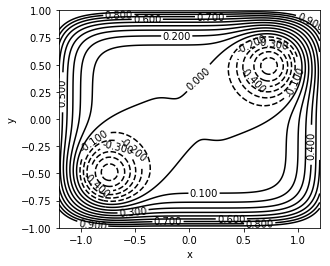

In [9]:
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)
X, Y = np.meshgrid(x,y)

coord = np.array([[xv, yv] for yv in y for xv in x])
V_val = V(coord)
V_val = V_val.reshape((len(y), len(x)))

fig, axs = plt.subplots(1)
#mapp = axs.imshow(V_val, extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
axs.set_xlabel('x')
axs.set_ylabel('y')
#fig.colorbar(mapp)

levels = np.arange(-1.5 , 1., 0.1)
CS = axs.contour(X, Y, V_val, levels, colors='k')
axs.clabel(CS, inline=1, fontsize=10, )
axs.set_aspect('equal')


In [10]:
# get the trainingset from simulation
trainset = arcd.base.utils.load_trainset(storage)

Restoring RCModelSelector without model.If used together with arcd.TrainingHook you can ignore this warning, otherwise please take care of resetting the model yourself.


In [11]:
model_file = storage_file + '_RCmodel.pckl'
model = arcd.base.utils.load_model(model_file, storage=storage)

# do a HIPR to see which inputs we should take

In [12]:
hipr = arcd.analysis.HIPRanalysis(model, trainset)
hipr_plus_losses = hipr.do_hipr_plus()

<BarContainer object of 22 artists>

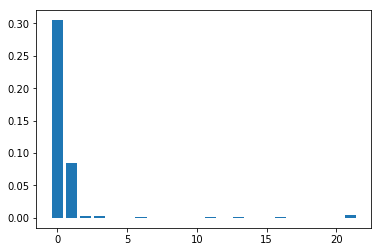

In [13]:
fig, axs = plt.subplots(1)
plt.bar(np.arange(len(hipr_plus_losses)-1), hipr_plus_losses[:-1] - hipr_plus_losses[-1]) 

# now the Symbolic regression

In [14]:
import pyaudi
import sympy as sp

In [15]:
# find the most relevant coordinates, i.e. where loss difference is maximal
loss_plus_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]
max_idxs = np.argsort(loss_plus_diffs)[::-1]
descriptors = trainset.descriptors
shot_results = trainset.shot_results

In [16]:
# resort such that we can use them for SymReg

n = 2 # lets take the two most relevant inputs for SymReg

# take only every 10th step to speed up stuff a bit
skip = 10
xt = [pyaudi.gdual_vdouble(descriptors[::skip, i]) for i in max_idxs[:n]]
yt = shot_results[::skip]

# take all for test
xtf = [pyaudi.gdual_vdouble(descriptors[:, i]) for i in max_idxs[:n]]
ytf = shot_results[:]

In [17]:
# initialize random expression
expression = arcd.symreg.initialize_random_expression(n, 1, kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp']) # we could also add 'sin' and 'sig'

In [18]:
# choose a loss function and a complexity regularization
lossFX = arcd.symreg.losses.binom_loss
complex_fx = lambda ex: arcd.symreg.losses.operation_count(ex, fact=0.00001)
complex_fx_reduced = lambda ex: arcd.symreg.losses.operation_count(ex, fact=0.000001)

# there are also other complexity penalties available
# arcd.symreg.losses.active_genes_count
# arcd.symreg.losses.l1_regularization
# arcd.symreg.losses.l2_regularization (not really a complexity penalty, but sometimes useful)

In [19]:
# optimize the expression
lossL = []
genesL = []
weightsL = []
n_iter = 4  # do it n_iter times in a row to get a feeling for the stability of th result
for _ in range(n_iter):
    expression = arcd.symreg.initialize_random_expression(n, 1, kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'])
    loss, genes, weights = arcd.symreg.optimize_expression(expression, 4, 100, xt, yt, lossFX, complexity_regularization=complex_fx,
                                                           newtonParams={'steps':100})  # newton steps is what makes up most of the runtime,
                                                                                        # however if it is to small expressions will not converge
                                                                                        # before the fitness evaluation
                                                                                        # this can be seen from having many similar expression with different coeffs
    lossL.append(loss)
    genesL.append(genes)
    weightsL.append(weights)

/homeloc/scratch/hejung/conda-envs/arcd_devel/lib/python3.6/site-packages/numpy/linalg/linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [20]:
# print out the resulting equations
for l, g, w in zip(lossL, genesL, weightsL):
    expression.set(g)
    expression.set_weights(w)
    print('loss with regularization on training data: ', l)
    print('losss without regularization on all data: ', sum(lossFX(expression, xtf, ytf).constant_cf))
    print(expression.simplify(['x{:d}'.format(idx) for idx in max_idxs[:n]], subs_weights=True))
    print()

loss with regularization on training data:  0.5210805025188583
losss without regularization on all data:  0.5708545781072013
[3.36470893369701*x0 + x1*(0.165281368625353*exp(-5.8848783967783*x0 - 2.58698876097569*x1) + 0.8246710213576)]

loss with regularization on training data:  0.526353802262725
losss without regularization on all data:  0.5663335146403891
[3.64280337840319*x0 + 1.59128315746784*x1]



In [21]:
from scipy.special import expit as sigmoid  # useful for transform RC values to probabilities

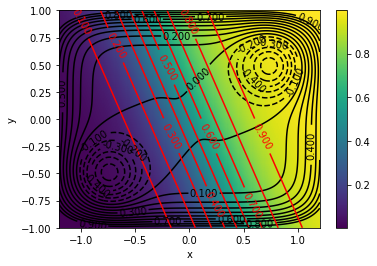

In [23]:
# choose an expression to plot and the weights + genes to the values we saved
genes = genesL[1]
weights = weightsL[1]
expression.set(genes)
expression.set_weights(weights)

# plot the found reaction coordinate onto the potential surface
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)
X, Y = np.meshgrid(x,y)

coord = np.array([[xv, yv] for yv in y for xv in x])
V_val = V(coord)
V_val = V_val.reshape((len(y), len(x)))

fig, axs = plt.subplots(1)
axs.set_xlabel('x')
axs.set_ylabel('y')

levels = np.arange(-1.5 , 1., 0.1)
CS = axs.contour(X, Y, V_val, levels, colors='k')
axs.clabel(CS, inline=1, fontsize=10, )
axs.set_aspect('equal')


coord_gdual = [pyaudi.gdual_vdouble(coord[:, i]) for i in range(coord.shape[1])]
rc = expression(coord_gdual)  # this is now a list of gdual_vdoubles
# since we trained with the binomial loss the RC only has one entry, the RC towards B
rc = np.array(rc[0].constant_cf) # convert to a numpy array, i.e. take only the values and ignore the higehr order derivates  
rc_mat = rc.reshape((len(y), len(x)))

mapp = axs.imshow(sigmoid(rc_mat), extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
levels = np.arange(0. , 1., 0.1)
CS = axs.contour(X, Y, sigmoid(rc_mat), levels, colors='r')
axs.clabel(CS, inline=1, fontsize=10, )

fig.colorbar(mapp)